# Trabajo Práctico 4: Redes

<p style="text-align: justify;">
En el marco de la materia optativa *Ciencia de Datos* estudiamos las técnicas de Teoría de Grafos a partir del análisis de la red de colaboraciones científicas mediante el paquete de Python [**networkx**](https://networkx.github.io/). En la [página web de la materia](http://www.dc.uba.ar/materias/cienciadatos) se encuentran disponibles los [datos](http://www.dc.uba.ar/materias/cienciadatos/tps/tp4/data.csv/view) utilizados, así como también las [referencias teóricas](http://www.dc.uba.ar/materias/cienciadatos/teoricas/teorica-Redes.pdf/view) y la [guía](http://www.dc.uba.ar/materias/cienciadatos/tps/tp4/Redes.pdf/view) para el desarrollo de los análisis correspondientes. <br>

<p style="text-align: justify;">
En el presente trabajo se analiza la red de colaboraciones científicas de publicaciones de física de altas energías del repositorio
ArXiv como una red compleja. 
</p> 

## Tabla de Contenidos 

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [0. Datos](#datos)
    - [0.1. Imports](#paquetes)  
    - [0.2. Carga y limpieza de datos](#limpieza)  
- [1. Creación del grafo](#grafo)
- [2. Distribución de grado](#grado)
- [3. Componentes conexas](#componentes)
- [4. Tamaños de vecindades](#vecindades)
- [5. Mundos pequeños](#mundospequeños)
- [6. Estrellas](#estrellas)
<!-- /MarkdownTOC -->

<a name="datos"></a>
## 0. Datos

<p style="text-align: justify;">
El archivo `data.csv` contiene una lista de publicaciones de física de altas energías del repositorio ArXiv. En esta práctica vamos a estudiar el grafo de colaboraciones entre autores, en el que los nodos representan autores y las aristas coautorías. Vamos a usar un grafo simple no dirigido, en el que basta una coautoría para que haya una conexión entre dos autores.
</p> 

<a name="paquetes"></a>
## 0.1. Imports

<p style="text-align: justify;">
Cargamos los paquetes de Python a utilizar.
</p> 

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import pickle
import itertools
import networkx as nx
import collections 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os.path
import random 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a name="limpieza"></a>
## 0.2. Carga y limpieza de datos

#### Levantamos los datos del csv

Para cada publicación se cuenta con el año, un código relacionado con la revista y el tema, la revista, los autores y el título.

In [3]:
with open('data.csv', 'r') as f:
    rows = [[c.strip() for c in l.split(',', 4)]
             for l in f]


In [4]:
papers = pd.DataFrame(rows, columns=['year', 'id', 'journal', 'authors', 'title'])

In [5]:
papers.head()

,year,id,journal,authors,title
0,1992,B368,Nucl.Phys.,Horne & Horowitz,Exact Black String Solutions in Three Dimensions
1,1992,B278,Phys. Lett.,Mikovic,Hamiltonian construction of W-gravity actions
2,1991,A6,Mod. Phys. Lett.,Huitu & Nemeschansky,Supersymmetric Gelfand-Dickey Algebra
3,1992,B373,Nucl.Phys.,Witten,Ground Ring Of Two Dimensional String Theory
4,1991,A6,Mod.Phys.Lett.,Intriligator,Fusion Residues


####  Limpiamos los datos
<p style="text-align: justify;">
En una primera inspección de la tabla de datos se observa que para ciertos casos la información provista ó bien no está ordenada correctamente ó está incompleta ó hay demás. Se filtraron estos casos y se continúa con la generación del grafo.
</p> 

In [6]:
banned_indexs = [2114, 6166, 6167, 6396, 6397, 6398, 7189]

In [7]:
papers.loc[banned_indexs]

,year,id,journal,authors,title
2114,1994,B328,Phys.Lett.,Nikolaev & Zakharov & IKP & Juelich & Juelich ...,The spectrum and solutions of the generalized ...
6166,1995,B349,lectures in Formation and Interactions of Topo...,,None
6167,NATO ASI B349,ed A.-C. Davis,R.,Carter,Dynamics of Cosmic Strings and other Brane models
6396,1997,P21,GROUP21,Physical Applications and Mathematical Aspects of,None
6397,Geometry,Groups and Algebras,vol. 2,eds. H.-D. Doebner e.a. World Sci.,
6398,Singapore,1997) p.,Kanatchikov,Novel algebraic structures from the polysymple...,None
7189,1998,E57,Phys.Rev.,Caiani & Casetti & Clementi & Pettini & Pettin...,Geometry of dynamics and phase transitions in ...


In [8]:
papers = papers.drop(papers.index[banned_indexs])

In [9]:
papers.to_csv('data.limpia.csv')

<a name="grafo"></a>
## 1. Creación del grafo

#### Extraemos todos los autores

In [10]:
papers = pd.read_csv('data.limpia.csv')

In [11]:
def authors_from_text(text):
    "Devuelve la lista de autores de texto como 'A & B & C'"
    s = text.split('&')
    return [x.strip() for x in s]

In [12]:
authors = [author
           for text in papers['authors']
           for author in authors_from_text(text)]

#### Extraemos las coautorías

In [13]:
co_authors = [list(itertools.combinations(set(authors_from_text(authors)), 2))
              for authors in papers['authors']]
co_authors = [x for x in co_authors if len(x) != 0]
co_authors = [co_autoria 
              for co_autorias in co_authors
              for co_autoria in co_autorias]

#### Creamos el grafo

In [14]:
grafo_citas = nx.Graph()

In [15]:
grafo_citas.add_nodes_from(authors)

In [16]:
grafo_citas.add_edges_from(co_authors)

La cantidad de nodos y links que forman el grafo son:

In [17]:
print('# de nodos: {}'.format(len(grafo_citas.nodes())))
print('# de links: {}'.format(len(grafo_citas.edges())))

# de nodos: 4003
# de links: 7782


Ploteamos la red para un layout predeterminado

In [18]:
pos = nx.drawing.spring_layout(grafo_citas)

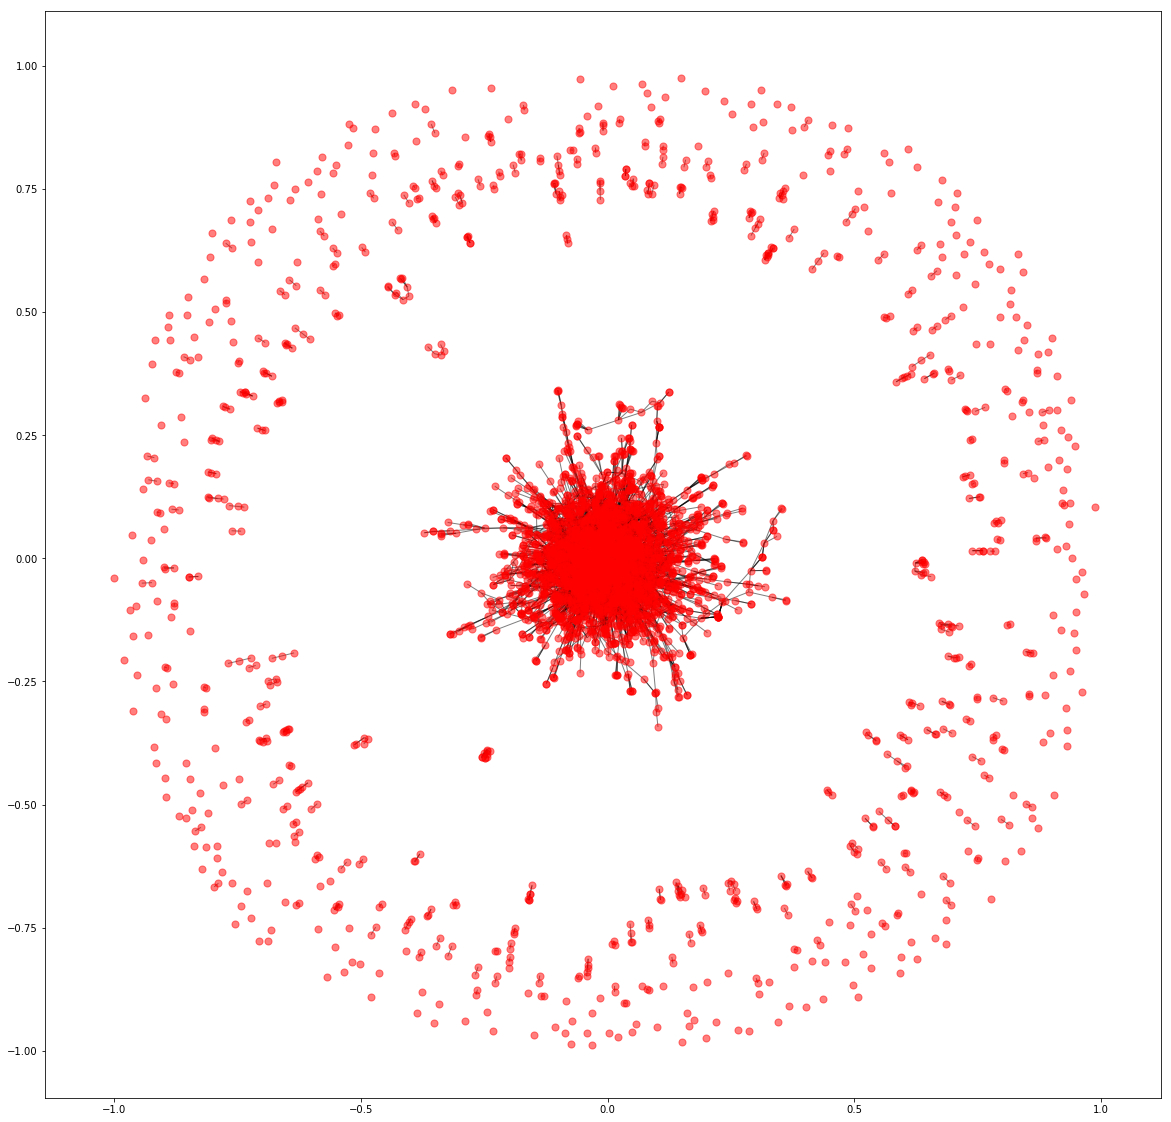

In [19]:
plt.figure(figsize(20, 20))
nx.draw_networkx(grafo_citas, pos, with_labels=False, node_size=50, alpha=0.5)

En el grafo se observa un núcleo con una gran cantidad de nodos conectados entre sí, formando una componente gigante. A su alrededor se disponen aquellos nodos sin conexiones o con pocas (~5).

A continuación se emplean herramientas específicas para caracterizar el grafo y el comportamiento de sus partes.

<a name="grado"></a>
##  2. Distribución de Grado

Para comenzar con la descripción del grafo se estudiará la distribución de grado de cada nodo.

In [20]:
def get_degree_values(G):
    #degree_values = [list(G.degree())[x][1] for x in range(len(G.degree()))]
    degree_values = [len(nbrs) for n,nbrs in G.adj.items()]
    return degree_values

In [21]:
deg = get_degree_values(grafo_citas)
count = collections.Counter(sorted(deg))


Se grafica la distribución de grados de nodos en diferentes escalas para decidir cuál es la más apropiada en este caso.

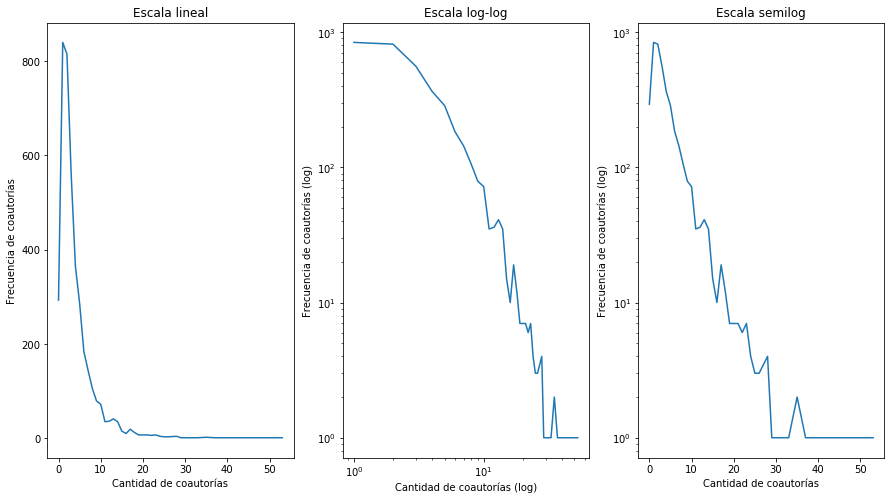

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
xs = list(count.keys())
ys = list(count.values())

sca(axs[0])
plot(list(count.keys()), list(count.values()))
xlabel('Cantidad de coautorías')
ylabel('Frecuencia de coautorías')
title('Escala lineal')

sca(axs[1])
loglog(list(count.keys()), list(count.values()))
xlabel('Cantidad de coautorías (log)')
ylabel('Frecuencia de coautorías (log)')
title('Escala log-log')

sca(axs[2])
semilogy(list(count.keys()), list(count.values()))
xlabel('Cantidad de coautorías')
ylabel('Frecuencia de coautorías (log)')
title('Escala semilog')
plt.show()

Eliminamos las colas (vemos hasta 30 co-autorías y eliminamos los autores sin co-autorías)

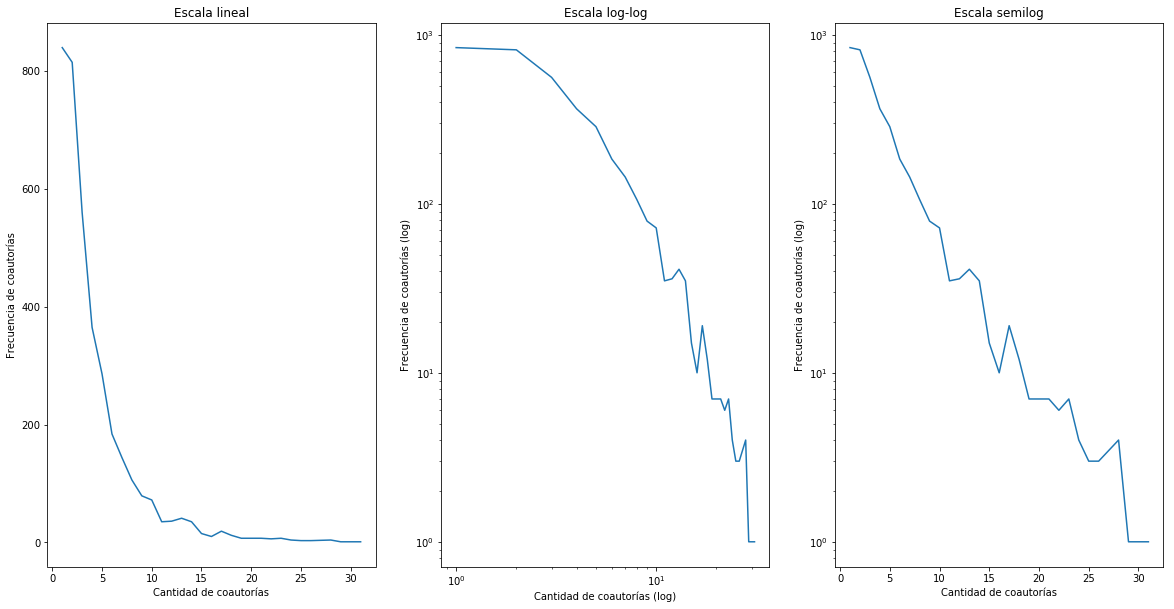

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
sca(axs[0])
plot(xs[1:30], ys[1:30])
xlabel('Cantidad de coautorías')
ylabel('Frecuencia de coautorías')
title('Escala lineal')

sca(axs[1])
loglog(xs[1:30], ys[1:30])
xlabel('Cantidad de coautorías (log)')
ylabel('Frecuencia de coautorías (log)')
title('Escala log-log')

sca(axs[2])
semilogy(xs[1:30], ys[1:30])
xlabel('Cantidad de coautorías')
ylabel('Frecuencia de coautorías (log)')
title('Escala semilog')
plt.show()

<p style="text-align: justify;">
Vale recordar que si los datos se ajustan a una recta para una escala logarítmica en ambos ejes la distribución es del tipo Ley de potencias mientras que si dicha escala es logarítmica sólo en el eje $y$ la distribución es exponencial. Teniendo en cuenta que con una inspección cualitativa no se puede elegir con seguridad si estamos en presencia de un caso o el otro, realizamos un ajuste lineal y se reporta el valor de $R^2$ para ambos casos.
</p>

In [24]:
exp_rs = sm.OLS(np.log(ys[1:]), xs[1:]).fit()
print('Exp R^2: {:.4f}'.format(exp_rs.rsquared))
power_rs = sm.OLS(np.log(ys[1:]), np.log(xs[1:])).fit()
print('Power-law R^2: {:.4f}'.format(power_rs.rsquared))

Exp R^2: 0.1372
Power-law R^2: 0.3329


<p style="text-align: justify;">
En ninguno de los dos ajustes se obtiene un resultado contundente en cuanto a la linealidad del gráfico anailzado. Sin embargo, el valor de $R^2$ obtenido para el caso de la ley de potencias es mayor, por lo que en caso de ser necesario, se tomará este resultado.
</p>

<a name="componentes"></a>
##  3. Componentes conexas

<p style="text-align: justify;">
En esta sección se quiere estudiar si la red está completamente conectada y de no ser así, se busca caracterizar, a través de su tamaño y frecuencia de aparición, los subgrupos que puedan formarse dentro del grafo original. El mayor de estos subconjuntos se denominada "componente conexa gigante".
</p>

In [25]:
nx.is_connected(grafo_citas)

False

In [26]:
nx.number_connected_components(grafo_citas)
print('Cantidad de componentes conexas: {}'.format(nx.number_connected_components(grafo_citas)))

Cantidad de componentes conexas: 530


In [27]:
components = list(nx.connected_components(grafo_citas))
subgrafo_citas = list(nx.connected_component_subgraphs(grafo_citas))

#### Componente gigante

Se define y grafica la componente gigante del grafo

In [28]:
components_sorted = sorted(subgrafo_citas, key=len, reverse=True)
giant_component = components_sorted[0]
print('Cantidad de nodos: {}'.format(len(giant_component.nodes())))
print('Cantidad de links: {}'.format(len(giant_component.edges())))

Cantidad de nodos: 3016
Cantidad de links: 7147


In [29]:
components_id = list(enumerate(components))  # :: [(id, componente)]
node_to_id = dict([(nodo, id_componente)  # :: nodo -> id_componente
                   for id_componente, nodos_componentes in components_id
                   for nodo in nodos_componentes])
nodes_ids = [node_to_id[n] for n in grafo_citas.nodes()]  # [id_componente] para cada nodo

In [30]:
nx.is_connected(giant_component)

True

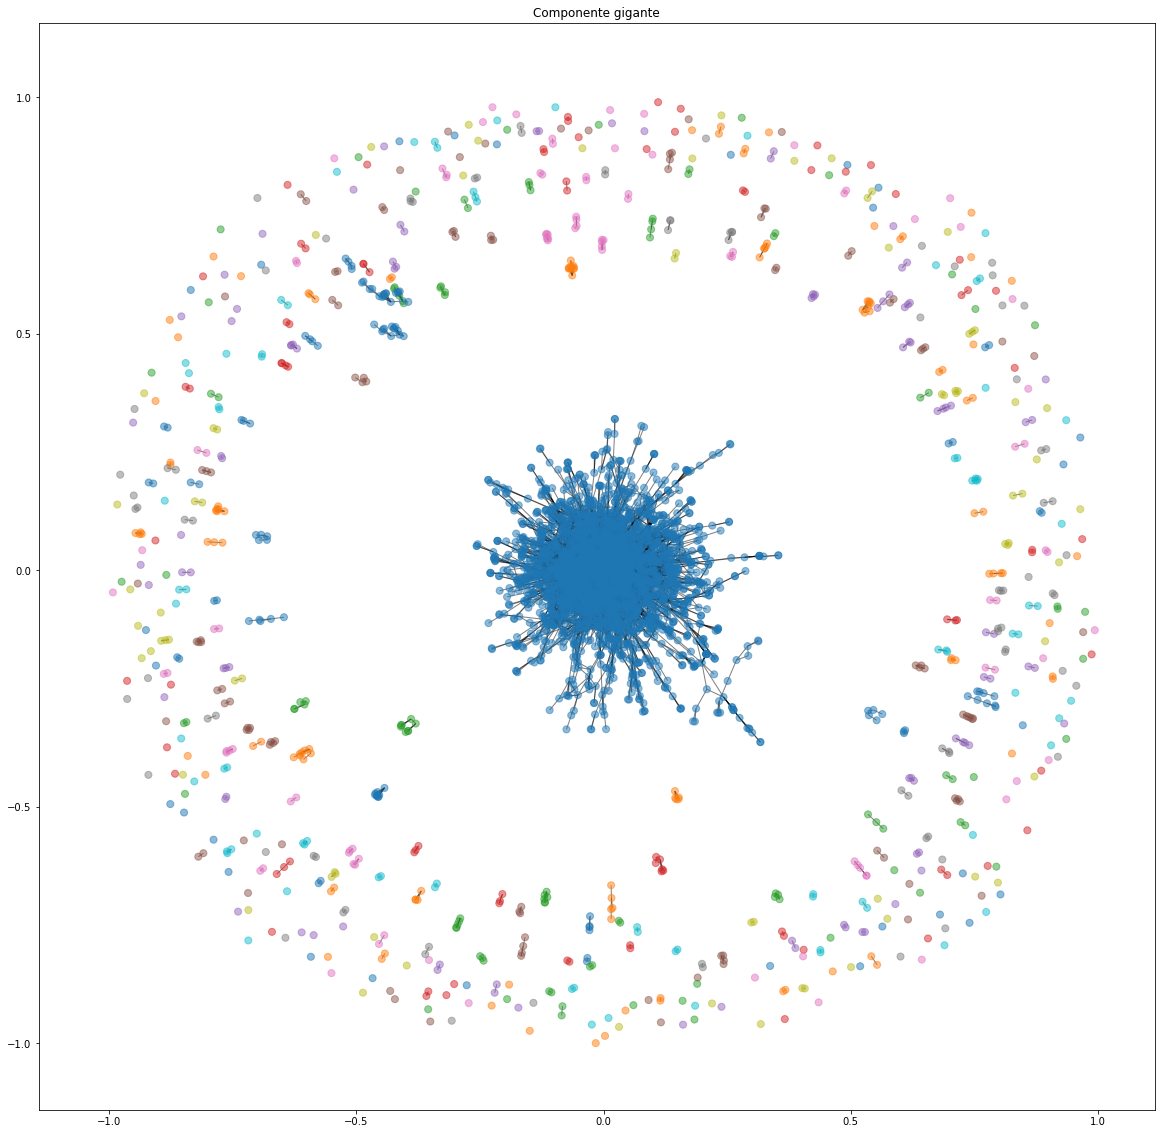

In [31]:
plt.figure(figsize(20, 20))
nx.draw_networkx(grafo_citas, pos=pos, node_size=50, alpha=0.5, 
                 node_color=nodes_ids, with_labels=False, cmap=cm.tab10)
title('Componente gigante')
plt.show()

<p style="text-align: justify;">
En el gráfico se observa la componente gigante del grafo en color azul compuesta por 3016 nodos de los 4003 totales y 7147 links de 7782. Tal como se esperaba, aquí es donde se encuentra la mayor densidad de nodos y enlaces describiendo una fuerte interacción en las publicaciones de los autores correspondientes. Esto coincide con lo observado y reportado en la primer representación del grafo como el "núcleo" de la red.
</p>

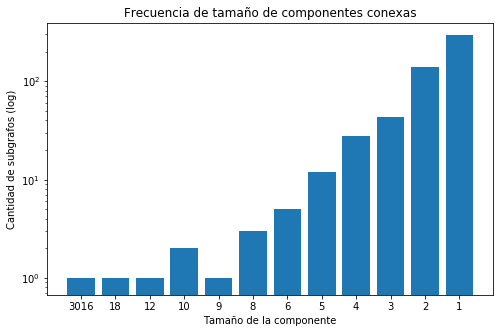

In [32]:
components_sizes = [len(c) for c in components]
c = collections.Counter(components_sizes)
xs = sorted(c.keys(), reverse=True)
ys = [c[x] for x in xs]
figure(figsize=(8, 5))
bar(range(len(xs)), ys, tick_label=xs, log=True)
title('Frecuencia de tamaño de componentes conexas')
xlabel('Tamaño de la componente')
_ = ylabel('Cantidad de subgrafos (log)')
plt.show()

<p style="text-align: justify;">
Por último, en este histograma se muestra la frecuencia del tamaño de las diferentes componentes conexas que integran el grafo. Como ya fue observado anteriormente hay una única componente gigante de 3016 nodos mientras que componentes de un único nodo hay del orden de 100, es decir ~100 del total de los nodos están no conectados. La próxima componente de mayor tamaño posee solamente 18 nodos y la sigue una de 12. Como era de esperarse a partir de la visualización anterior del grafo, el mayor número de componentes conexas poseen pocos nodos (=< 8) lo que significa que, sin considerar la componente gigante, la mayoría de los autores tienen publicaciones con un grupo reducido de colegas.
</p>

<a name="vecindades"></a>
##  4. Tamaños de vecindades

<p style="text-align: justify;">
En este caso se quieren analizar las vecindades presentes en la componente gigante. Para esto, se comienza eligiendo un nodo al azar, _nodo semilla_, y nos alejaremos de él a través de las aristas que lo conectan con sus vecinos. Así en cada paso se agregarán nuevos nodos (_nodos agregados_) que serán los 1ros vecinos de cada _nodo visitado_. Se busca cuantificar la dinámica en el aumento de los nodos agregados y visitados.
</p>

In [33]:
def roberto_carlos(G, nodo_inicial):
    """
    Calcula el esparcimiento en el grafo a partir del nodo inicial.
    
    Args:
        G: Grafo inicial
        nodo_inicial: nodo del grafo a partir del cual se calcula esparcimiento
        
    Return:
        {
            'visitados': nodos visitados en cada paso,
            'agregados': nodos agregados en cada paso
        }
    """
    por_ver = set([nodo_inicial])
    vistos = set()
    visitados = []
    agregados = []
    while len(por_ver) > 0:
        proximos = set([vecino
                        for n in por_ver
                        for vecino in G[n]])
        por_ver = proximos - vistos
        agregados.append(len(por_ver))
        vistos = vistos | proximos
        visitados.append(len(vistos))
        
    return {
        'visitados': visitados,
        'agregados': agregados
    }

In [97]:
S = 30 # numero de nodos semilla elegido de manera random
elegidos_gigante = np.random.choice(giant_component.nodes(), size=S, replace=False)

In [98]:
df = pd.DataFrame.from_records(
    [roberto_carlos(giant_component, n) for n in elegidos_gigante]
)

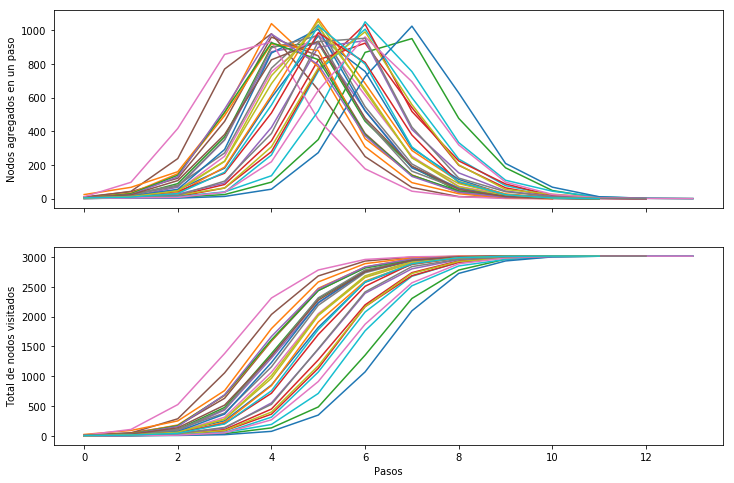

In [99]:
fig, axs = subplots(2, 1, figsize=(12, 8), sharex=True)
sca(axs[0])
for agregados in df['agregados']:
    plot(range(len(agregados)), agregados)
    
ylabel('Nodos agregados en un paso')

sca(axs[1])
for visitados in df['visitados']:
    plot(range(len(visitados)), visitados)
    
ylabel('Total de nodos visitados')
    
xlabel('Pasos')
plt.show()

<p style="text-align: justify;">
En el primero de los gráficos se muestran los nodos que se agregan en cada paso para 30 nodos semilla distintos elegidos de aleatoriamente. Se observa que en el primer paso se agregan menos de 200 nodos en todos los caso y luego este valor aumenta hasta alcanzar el pico máximo (correspondiente a 1000 nodos agregados) entre el 4to y el 7mo paso.
<br>
En el segundo gráfico se presenta la cantidad acumulada de nodos que se visitan para cada paso. Para el 7mo paso, en la mayoría de las iteraciones, se han recorrido ~3000 nodos, es decir, toda la componente gigante mientras que para el 10mo paso esto se observa en todos los casos.
<br>
Resulta interesante estudiar el número promedio de pasos que se requiere para alcanzar la mayor cantidad de nodos agregados al recorrido. Para esto se extraen los máximos del primer gráfico y a continuación se presenta un histograma.
</p>

In [100]:
maximos = [np.argmax(df['agregados'][j]) for j in range(len(df['agregados']))]

In [101]:
np.mean(maximos)
print('Promedio de pasos necesarios para agregar el mayor número de nodos: {}'.format(np.mean(maximos)))

Promedio de pasos necesarios para agregar el mayor número de nodos: 5.166666666666667


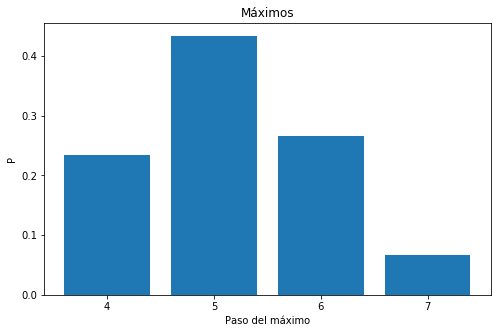

In [102]:
plt.figure(figsize=(8,5))
count = collections.Counter(maximos)
xm = sorted(count.keys(), reverse=False)
ym = [count[x] for x in xm]
bar(range(len(xm)), ym/sum(list(count.values())), tick_label=xm)
title('Máximos')
xlabel('Paso del máximo')
ylabel('P')
plt.show()

<p style="text-align: justify;">
Para casi el 50% de las iteraciones realizadas se agregan la mayor cantidad de nodos en el 5to paso y para el 6to paso el 90% de las iteraciones ya alcanzaron el máximo valor de nodos agregados. Estos valores permiten relacionar el comportamiento de las vecidandes de la componente gigante con el experimento realizado por Milgram 1967. Resumidamente, el autor encontró que se necesitan 6 intermediarios para hacer llegar una carta hasta un agente de bolsa en Boston permitiendo envíos únicamente entre gente conocida. Aplicando este razonamiento a nuestra red de coautorías, se tiene que cada autor (de la máxima componente) estaría a seis conexiones con otros autores de trabajar en una publicación con 1000 autores más de la componente gigante.
</p>

<a name="mundospequeños"></a>
##  5. Mundos pequeños

<p style="text-align: justify;">
Las redes de mundo pequeño son redes en las que se puede llegar de un nodo a otro con relativamente pocos pasos entre ellos. Están caracterizadas por propiedades topológicas específicas como pueden ser que presentan un camino mínimo medio bajo y un coeficiente de clustering medio alto.
</p>

<p style="text-align: justify;">
Calculamos el coeficiente de clustering promedio de la componente gigante del grafo. Para ello, calculamos el coeficiente de clustering de cada nodo y después obtenemos el promedio entre todos los nodos
</p>

In [103]:
cc = nx.clustering(giant_component)

In [104]:
cc_list = list(cc.values())
mean(cc_list)

0.47861863375943958

Pero también podemos utilizar la función **nx.average_clustering** para la que observamos que obtenemos el mismo valor de forma directa

In [105]:
average_cc = nx.average_clustering(giant_component)
average_cc

0.4786186337594398

Calculamos el camino mínimo medio

In [106]:
nx.average_shortest_path_length(giant_component)

6.0536554627393535

<p style="text-align: justify;">
Para analizar si las métricas obtenidas muestran una topología no trivial del grafo como por ejemplo propiedades de mundo pequeño, las comparamos con las medidas obtenidas para un grafo aleatorio con la misma distribución de grado.
</p>

### Red de topología random preservando la distribución de grado de la red original

<p style="text-align: justify;">
Una forma de generar un grafo aleatorio con la misma distribución de grado que el grafo original resulta a partir de repetir iterativamente el proceso de seleccionar 2 pares de nodos conectados e intercambiar sus ejes. De esta manera, si tengo las conexiones A-B y C-D, puedo recablear la red intercambiando los nodos conectados tal que queden A-D y C-B, siempre y cuando las nuevas conexiones no se encuentren ya en la red y no sean autoconexiones (para que la distribución de grado se mantenga exactamente igual)
</p>

In [107]:
def randomize_by_edge_swaps(G, num_iterations=10):
    """
    Randomiza una red preservando su distribución de grados. Para esto selecciona 2 pares de nodos conectados e intercambia sus links.
    Es decir, agarra A-B y C-D e intercambia las conexiones de manera tal que quedan A-D y C-B.
    Esquema:
         A   C
         |* *|           | par de links seleccionados
         | * |
         |* *|           * par de links nuevos
         B   D
    Para hacer este intercambio, el algoritmo:
        - admite previamente el troque del orden de los nodos del enlace
        - se fija que luego del intercambio de links no queden self-loops
        - se fija que luego del intercambio no queden links repetidos
    
    Args:
        G: Grafo inicial
        num_iterations: numero de veces que recorre aleatoriamente un total de links igual al del grafo inicial y realiza el intercambio de conexiones entre pares de nodos si se cumplen las condiciones necesarias para el intercambio (por default usa num_iterations=10)
        
    Return:
        {
            G_random: Grafo randomizado preservando la distribución de grados del grafo inicial
        }
    
    Packages:
        random
        networkx
    """
    G_random = G.copy()
    #edge_list = G_random.edges() #v1.1
    edge_list = list(G_random.edges()) #v2.0
    num_edges = len(edge_list)
    total_iterations = num_edges * num_iterations

    executed_iterations = []
    for i in range(total_iterations):
        rand_index1 = int(round(random.random() * (num_edges - 1)))
        rand_index2 = int(round(random.random() * (num_edges - 1)))
        original_edge1 = edge_list[rand_index1]
        original_edge2 = edge_list[rand_index2]
        head1, tail1 = original_edge1
        head2, tail2 = original_edge2

        # Permito la posibilidad de intercambiar el orden de los nodos del 1er link con probabilidad random
        if random.random() >= 0.5:
            head1, tail1 = tail1, head1

        # Condición para no considerar self-loops
        if head1 == tail2 or head2 == tail1:
            continue

        # Condición para no agregar un link que ya existe
        if G_random.has_edge(head1, tail2) or G_random.has_edge(
                head2, tail1):
            continue

        # Hago el intercambio de links
        original_edge1_data = G_random[head1][tail1]
        original_edge2_data = G_random[head2][tail2]

        G_random.remove_edges_from((original_edge1, original_edge2))

        new_edge1 = (head1, tail2, original_edge1_data)
        new_edge2 = (head2, tail1, original_edge2_data)
        G_random.add_edges_from((new_edge1, new_edge2))

        edge_list[rand_index1] = (head1, tail2)
        edge_list[rand_index2] = (head2, tail1)
        
        executed_iterations.append(i)

    #print('# de links intercambiados: {}'.format(len(executed_iterations)))
    #print('# de iteraciones: {}'.format((num_edges * num_iterations)))
    #print('# de links del grafo: {}'.format(num_edges))
    assert len(G_random.edges()) == num_edges
    return G_random


In [108]:
grafo_citas_random = randomize_by_edge_swaps(grafo_citas)

Y para esta red random puedo calcular su separación en componentes y las propiedades de la componente principal

In [109]:
nx.number_connected_components(grafo_citas_random)

317

In [110]:
# identify largest connected component
components_sorted_random = sorted(nx.connected_component_subgraphs(grafo_citas_random), key=len, reverse=True)
giant_component_random = components_sorted_random[0]

In [111]:
print('Cantidad de nodos: {}'.format(len(giant_component_random.nodes())))
print('Cantidad de ejes: {}'.format(len(giant_component_random.edges())))

Cantidad de nodos: 3658
Cantidad de ejes: 7753


In [112]:
nx.average_clustering(giant_component_random)

0.002417221541488005

In [113]:
nx.average_shortest_path_length(giant_component_random)

5.115435050973641

<p style="text-align: justify;">
Pero también puedo definir otros métodos para randomizar el grafo. Por ejemplo, puedo armar una lista de todos los extremos de las conexiones (nodos conectados), dejando repetidos los que aparecen en varios links, y recablear considerando que no queden links repetidos ni autoconexiones
</p>

In [114]:
def randomize_by_rewiring(G):
    """
    Randomiza una red preservando su distribución de grados. Para esto arma una lista de todos los extremos de las conexiones,
    dejando repetidos los que aparecen en varios links, y recablea considerando:
        - que no queden self-loops
        - que no queden links repetidos
    
    Args:
        G: Grafo inicial
        
    Return:
        {
            G_random: Grafo randomizado preservando la distribución de grados del grafo inicial
        }
    
    Packages:
        random
        networkx
        numpy as np
        collections
    """
    #edge_list = G.edges() #v1.1
    edge_list = list(G.edges()) #v2.0
    edges = set( [tuple(e) for e in edge_list ]) 
    
    stubs = [ ]
    [ stubs.extend(e) for e in edges ]
    
    stub_counter = collections.Counter(stubs)

    new_edges = set()

    #nodes = np.array([ stub for stub,count in stub_counter.iteritems() if count!=0 ]) #Python2
    nodes = np.array([ stub for stub,count in stub_counter.items() if count!=0 ]) #Python3

    while len(nodes)>0:

        # valores iniciales para nuevos links
        first,second = -1,-1

        # elige links que no sean self-loops
        while first == second and len(nodes)>1:
            first,second = np.random.choice(nodes,size=(2,),replace=False)

        # agrego el link mientras no sea self-loop, ni ya esté en el nuevo grafo recableado
        if first!=second and \
           (first,second) not in new_edges and \
           (second,first) not in new_edges and \
           len(nodes)>1:
            new_edges.add((first,second))
            stub_counter[first] -= 1
            stub_counter[second] -= 1
        else:
            # si no, elige un link aleatoriamente y vuelve a poner sus nodos para futuras selecciones
            edge = random.sample(new_edges,1)[0]
            new_edges.remove(edge)
            stub_counter[edge[0]] += 1
            stub_counter[edge[1]] += 1

        # actualizo nodes
        nodes = np.array([ stub for stub,count in stub_counter.items() if count!=0 ])

    G_random = nx.Graph()
    G_random.add_nodes_from(list(G.nodes))
    G_random.add_edges_from(list(new_edges))
    
    return G_random


O también puedo definir otros métodos de randomización aplicando funciones del paquete **networkx**

In [115]:
def nx_double_edge_swap(G):
    grafo_citas_random = nx.double_edge_swap(G, 5000,10000)
    return grafo_citas_random

In [116]:
def nx_configuration_model_cleaned(G):
    grafo_citas_random = nx.configuration_model(get_degree_values(G))
    # remuevo links repetidos
    grafo_citas_random = nx.Graph(grafo_citas_random)
    # remuevo self-loops
    grafo_citas_random.remove_edges_from(grafo_citas_random.selfloop_edges())
    return grafo_citas_random

In [117]:
def nx_expected_degree_graph(G):
    grafo_citas_random = nx.expected_degree_graph(get_degree_values(G), selfloops=False)
    return grafo_citas_random

In [118]:
def nx_random_degree_sequence_graph(G):
    grafo_citas_random = nx.random_degree_sequence_graph(get_degree_values(G))
    return grafo_citas_random

Evaluamos los resultados de los distintos métodos

In [119]:
randomize_methods = collections.OrderedDict({
    'randomize_by_edge_swaps': randomize_by_edge_swaps,
    'randomize_by_rewiring': randomize_by_rewiring,
    'nx_double_edge_swap': nx_double_edge_swap,
    'nx_configuration_model_cleaned': nx_configuration_model_cleaned,
    'nx_expected_degree_graph': nx_expected_degree_graph,
    'nx_random_degree_sequence_graph': nx_random_degree_sequence_graph
})

In [120]:
grafo_citas_random = collections.OrderedDict(
    [(k, method(grafo_citas)) for k, method in randomize_methods.items()]
    )

In [121]:
[nx.number_connected_components(G_random) for G_random in grafo_citas_random.values()]

[318, 367, 345, 317, 3970, 324]

<p style="text-align: justify;">
La cantidad de componentes obtenida para las redes random generadas mediante los distintos métodos parecen ser similares, con excepción del método **nx_expected_degree_graph**. Para este método se encontró una cantidad de componentes de un orden de magnitud mayor que para los métodos restantes, por lo que se espera que la componente gigante correspondiente tenga un tamaño mucho menor y diferencias en sus propiedades topológicas
</p>

In [122]:
nodes_giant_component_random = []
links_giant_component_random = []
cc_giant_component_random = []
d_giant_component_random = []
for G_random in grafo_citas_random.values():
    components_sorted_random = sorted(nx.connected_component_subgraphs(G_random), key=len, reverse=True)
    giant_component_random = components_sorted_random[0]
    nodes_giant_component_random.append(len(giant_component_random.nodes()))
    links_giant_component_random.append(len(giant_component_random.edges()))
    cc_giant_component_random.append(nx.average_clustering(giant_component_random))
    d_giant_component_random.append(nx.average_shortest_path_length(giant_component_random))
    #tabla = {'Nodos': len(giant_component_random.nodes()), 'Links': len(giant_component_random.edges()),
    #             'CC': nx.average_clustering(giant_component_random), 'd': nx.average_shortest_path_length(giant_component_random)
    #        }
    

In [123]:
tabla = collections.OrderedDict({'Nodos': nodes_giant_component_random, 'Links': links_giant_component_random,
         'CC': cc_giant_component_random, 'L': d_giant_component_random
        })

In [124]:
pd.DataFrame(tabla, index=grafo_citas_random.keys())

,Nodos,Links,CC,L
randomize_by_edge_swaps,3662,7758,0.002439,5.084099
randomize_by_rewiring,3550,7695,0.003340,5.457124
nx_double_edge_swap,3604,7725,0.012890,5.095614
nx_configuration_model_cleaned,3660,7738,0.003208,5.098047
nx_expected_degree_graph,34,458,0.876092,1.203209
nx_random_degree_sequence_graph,3646,7748,0.002387,5.089943


<p style="text-align: justify;">
Calculamos para la componente gigante de cada grafo random el número de nodos, de links, el coeficiente de clustering medio y el camino mínimo medio. Los valores obtenidos para los distintos métodos parecen ser similares, con excepción del método **nx_expected_degree_graph**.
</p>

<p style="text-align: justify;">
Evaluamos la distribución de grado de todos los métodos de randomización en comparación con la red original, para comprobar que efectivamente los métodos conservan la secuencia de grado
</p>

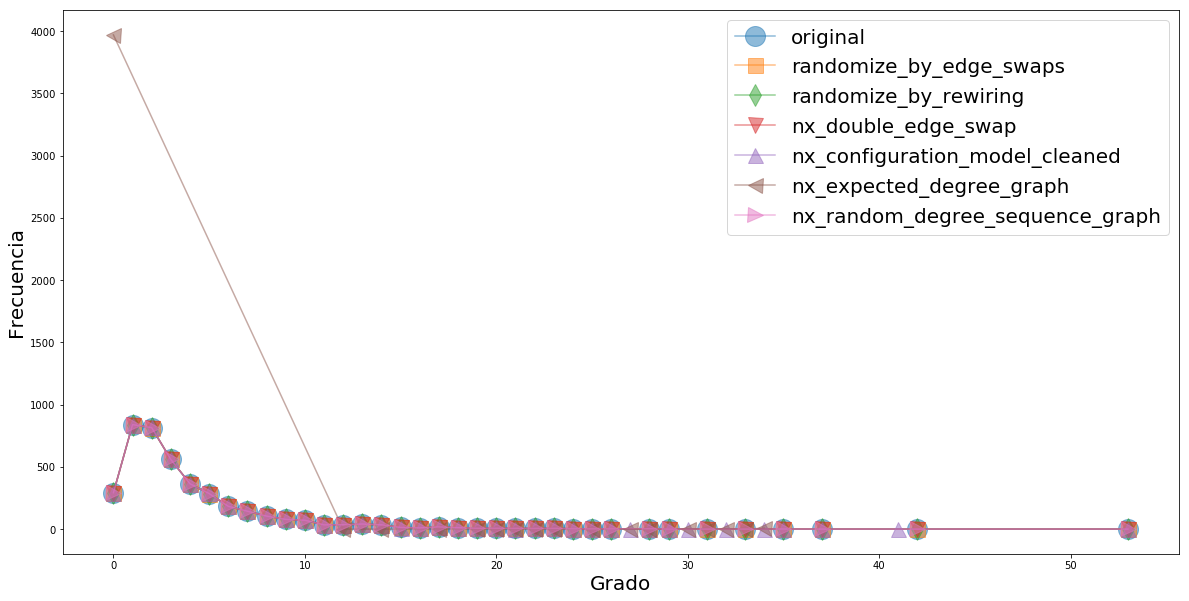

In [125]:
plt.figure(figsize(20, 10))
degrees = get_degree_values(grafo_citas)
count_degrees = collections.Counter(sorted(degrees))
plot(list(count_degrees.keys()), list(count_degrees.values()), label='original', alpha=0.5, marker='o', markersize=20)
markers = ['s','d','v','^','<','>']
i = 0
for name, G_random in grafo_citas_random.items():
    degrees_random = get_degree_values(G_random)
    count_degrees_random = collections.Counter(sorted(degrees_random))
    plot(list(count_degrees_random.keys()), list(count_degrees_random.values()), label=name, alpha=0.5, 
         marker=markers[i], markersize=15)
    i += 1
xlabel('Grado', size=20)
ylabel('Frecuencia', size=20)
legend(prop={'size': 20})
plt.show()

<p style="text-align: justify;">
Observamos que la mayoría de los métodos reproducen la distribución de grado de la red original, con excepción de los métodos **nx_expected_degree_graph**, que da muy diferente, y de **nx_configuration_model_cleaned**, que muestra diferencias sutiles. Pero los demás métodos parecen cumplir las condiciones de preservación de grado necesarias para la randomización.
</p>

### Topología de la red original en comparación con la random

<p style="text-align: justify;">
De los métodos explorados, utilizamos el de **randomize_by_edge_swaps** para generar un número de redes aleatorias (N = 10) con la misma distribución de grado de la red original, con el objetivo de observar si existen características no triviales de la topología de la red
</p>

In [126]:
N = 10
CC_giant_component_random = []
L_giant_component_random = []
for n in range(N):
    G_random = randomize_by_edge_swaps(grafo_citas)
    components_sorted_random = sorted(nx.connected_component_subgraphs(G_random), key=len, reverse=True)
    giant_component_random = components_sorted_random[0]
    CC_giant_component_random.append(nx.average_clustering(giant_component_random))
    L_giant_component_random.append(nx.average_shortest_path_length(giant_component_random))


In [127]:
average_cc = nx.average_clustering(giant_component)
L = nx.average_shortest_path_length(giant_component)
cc_random_mean = np.mean(CC_giant_component_random)
cc_random_std = np.std(CC_giant_component_random)
L_random_mean = np.mean(L_giant_component_random)
L_random_std = np.std(L_giant_component_random)

In [128]:
pd.DataFrame({'Original':{'CC': average_cc, 'L': L}, 'Random (mean)': {'CC': cc_random_mean, 'L': L_random_mean}, 'Random (std)':{'CC': cc_random_std, 'L': L_random_std}})

,Original,Random (mean),Random (std)
CC,0.478619,0.002735,0.000762
L,6.053655,5.100548,0.014536


<p style="text-align: justify;">
Observamos que la red presenta valores significativamente distintos de los obtenidos para las redes random, lo que refleja una topología no trivial ya que no se puede explicar a partir únicamente de la distribución de grado.
</p>

<p style="text-align: justify;">
Definimos la métrica *small-worldness* como la relación entre el cociente de los coeficientes de clustering medios para la red original y para la red random, y el cociente de los caminos mínimos medios para la red original y para la red random.
</p>

In [129]:
(average_cc/cc_random_mean)/(L/L_random_mean)

147.45224806781835

<p style="text-align: justify;">
El coeficiente de clustering medio es mucho mayor para la red original que para la red random, y el camino mínimo medio de la red original es mayor pero del orden de magnitud del obtenido para la red random. De esta manera, la medida de *small-worldness* es mayor que 1, por lo que la componente gigante de la red muestra una topología con características de red de mundo pequeño.
</p>

<a name="estrellas"></a>
##  6. Estrellas

<p style="text-align: justify;">
Por último, se busca identificar y estudiar el comportamiento de los nodos que están más conectados según algunas métricas de centralidad. Para llevarlo a cabo se decidió primeramente estudiar la centralidad de los nodos de la red a través de varias métricas. Luego, una vez identificado un nodo con alta centralidad se lo remueve y se observa cómo afecta esta remoción a la topología de la red. Haciendo varias iteraciones de este procedimiento, esto es eliminando recurrentemente los nodos de mayor centralidad de acuerdo a las diferentes métricas, se estudia la evolución de tamaño y conexión de la componente gigante. Comparamos los efectos en la componente gigante al remover nodos en orden de centralidad de acuerdo a una métrica (es decir, removiendo a cada paso el nodo de mayor centralidad), con los resultados obtenidos si se removieran nodos en orden aleatorio.
<br>
Se estudian las siguientes métricas: _degree, eigenvector, closeness_ y _betweeness_.
</p>

In [24]:
centrality_metrics = collections.OrderedDict({
    'degree': nx.degree_centrality,
    'eigen': nx.eigenvector_centrality,
    'closeness': nx.closeness_centrality,
    'betweeness': nx.betweenness_centrality
})

In [25]:
CENTRALITY_PKL = 'centrality_scores.pkl'
if not os.path.isfile(CENTRALITY_PKL):
    centrality_scores = collections.OrderedDict(
        [(k, metric(grafo_citas)) for k, metric in centrality_metrics.items()]
    )
    with open(CENTRALITY_PKL, 'wb') as f:
        pickle.dump(centrality_scores, f)
else:
    with open(CENTRALITY_PKL, 'rb') as f:
        centrality_scores = pickle.load(f)

In [132]:
percentile = .2

In [133]:
percentile_most_central = collections.OrderedDict(
    [(k, dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:int(len(scores) * percentile)]))
     for k, scores in centrality_scores.items()]
)

In [134]:
sizes = [sum([1 for centrals in percentile_most_central.values() if n in centrals])
         for n in grafo_citas.nodes()]
filtered_sizes = [s for s in sizes if s > 0]

In [135]:
pos = nx.drawing.spring_layout(grafo_citas)

1 366
2 356
3 198
4 382


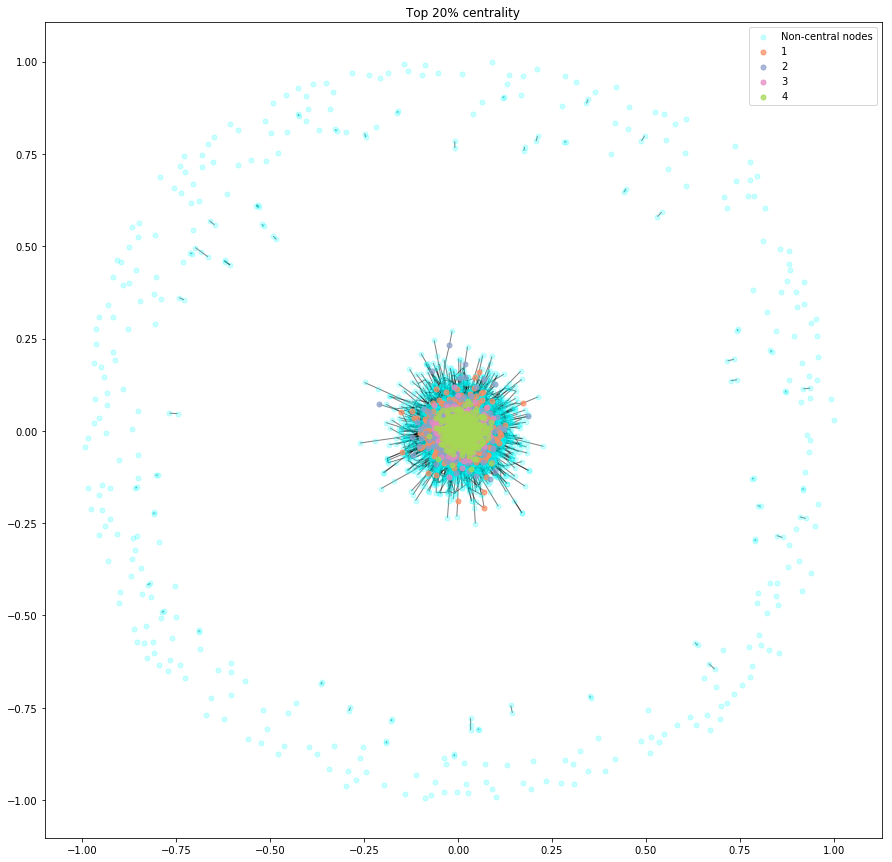

In [136]:
figure(figsize=(15, 15))
# pos = nx.layout.spring_layout(grafo_citas)
nx.draw_networkx_edges(grafo_citas, pos, alpha=0.5)

nx.draw_networkx_nodes(grafo_citas, pos, with_labels=False, node_size=25, 
                       nodelist=[n for n, s in zip(grafo_citas.nodes(), sizes) if s == 0],
                       node_color='cyan', alpha=0.2, label='Non-central nodes')

for size in range(1, 5):
    nl = [n for n, s in zip(grafo_citas.nodes(), sizes) if s == size]
    print(size, len(nl))
    nx.draw_networkx_nodes(grafo_citas, pos, with_labels=False, node_size=25, nodelist=nl, 
                           node_color=cm.Set2(size), alpha=0.75, label=str(size))
    
legend()
title('Top 20% centrality')
plt.show()

<p style="text-align: justify;">
En esta figura se colorearon los nodos según la cantidad de métricas en las que son centrales: si un nodo no es central le corresponde el color cyan, si es central en una sóla métrica le corresponde naranja, en dos azul, en tres rosa y por último si es central en las cuatro métricas que se están evaluando se pinta de verde.
<br>
De los nodos que no pertenecen a la componente gigante (~1000) se puede decir que gran parte de ellos son nodos no-centrales: únicamente 4 son centrales y lo son para una única métrica.
<br>
Respecto a la componente gigante, en ella se encuentran nodos de todos los casos, es decir hay nodos centrales para cuatro métricas e incluso nodos que no lo son para ninguna pasando por los casos intermedios. Esto nos permite tener una idea de cuán centrales son los nodos y cuántas métricas resultaría interesante tener en cuenta en la remoción de autores.
</p>

In [137]:
def plot_selectivity(centrality_scores, label=None):
    scores = np.array(centrality_scores)
    stops = np.linspace(max(centrality_scores), min(centrality_scores), 20)
    xs = np.linspace(0, 1, 20)
    ys = np.array([sum(scores > s) for s in stops]) / len(centrality_scores)
    plot(xs, ys, label=label)

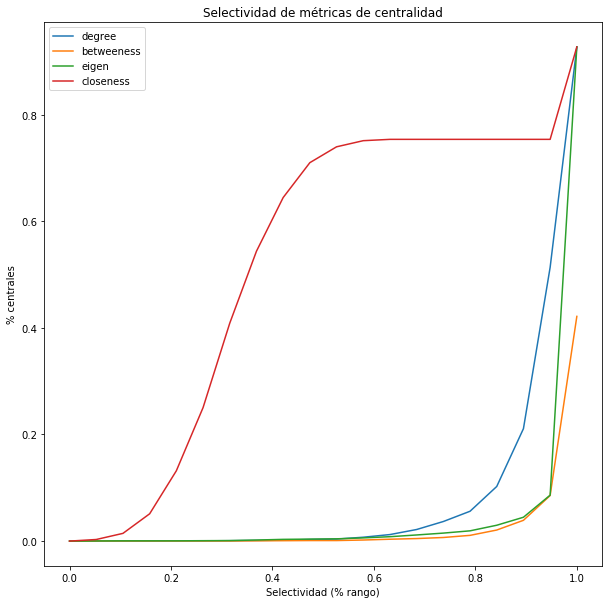

In [138]:
figure(figsize=(10, 10))
for name, scores in centrality_scores.items():
    plot_selectivity(list(scores.values()), name)
xlabel('Selectividad (% rango)')
ylabel('% centrales')
title('Selectividad de métricas de centralidad')
legend()
plt.show()

<p style="text-align: justify;">
En esta figura se muestra el comportamiento de la centralidad acumulada de la componente máxima a medida que se tienen en cuenta sus nodos más centrales. Por ejemplo para el caso de _degree_ se observan pocos nodos (en el rango de 0.8 a 1) con alto degree mientras que _closeness_ tiene otro tipo de comportamiento en el cual la curva crece más tempranamente y luego se convierte en una meseta para terminar creciendo nuevamente sobre el final al considerar el 90% de sus nodos centrales.
</p>

Procedemos a remover iterativamente los nodos por orden de centralidad

In [26]:
def eliminamos_centros(G, centrality_scores, pasos):
    """
    Elimina nodos centrales sucesivamente y calcula el tamaño de la componente gigante.
    
    Args:
        G: grafo
        centrality_scores: diccionario nodo -> score centralidad
        pasos: cantidad de pasos a realizar
        
    Return:
        lista de tamaños de componente gigante
    """
    g = G.copy()
    t_gigante = []
    nodos_centrales = [x[0] for x in sorted(centrality_scores.items(), key=lambda x: x[1])]
    while pasos > 0:
        c_c_gen = [list(x) for x in nx.connected_components(g)]
        c_gigante = max(c_c_gen, key=len)
        t_gigante.append(len(c_gigante))
        n_central = nodos_centrales.pop()
        # n_central = nodos_centrales[-1]
        # nodos_centrales = nodos_centrales[:-1]
        g.remove_node(n_central)
        pasos -= 1
        
    return t_gigante

In [27]:
#pasos = 1000
pasos = len(grafo_citas)

In [35]:
metrics_ts = dict([(name, eliminamos_centros(grafo_citas, scores, pasos))
                   for name, scores in centrality_scores.items()])

In [38]:
#R = 5
R = 10
random_scores = [dict(zip(grafo_citas.nodes(), np.random.uniform(size=len(grafo_citas))))
                 for _ in range(R)]

In [39]:
random_ts = np.array([eliminamos_centros(grafo_citas, rs, pasos) for rs in random_scores])

In [40]:
random_ts_mean = np.mean(random_ts, axis=0)

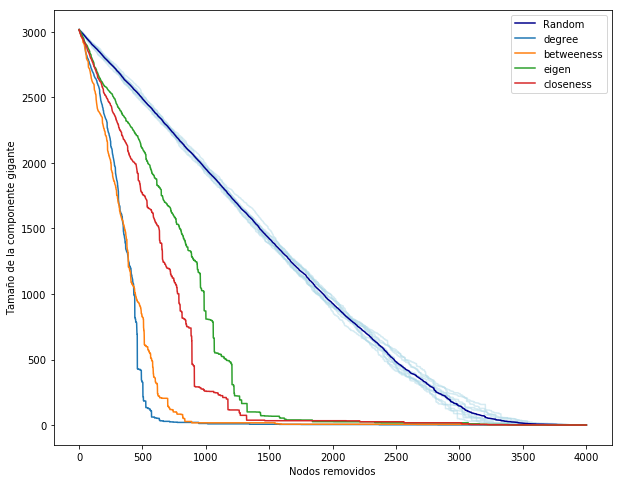

In [41]:
figure(figsize=(10, 8))

for ts in random_ts:
    plot(range(len(ts)), ts, color='lightblue', alpha=0.5)
    
plot(range(len(random_ts_mean)), random_ts_mean, color='darkblue', label='Random')

for name, ts in metrics_ts.items():
    plot(range(len(ts)), ts, label=name)
xlabel('Nodos removidos')
ylabel('Tamaño de la componente gigante')
legend()
plt.show()

<p style="text-align: justify;">
En este último gráfico se muestra la evolución del tamaño de la componente gigante cuando se remueven nodos centrales según diferentes métricas y nodos al azar.
<br>
En el caso de _degree_ y _betweeness_ se observa que al remover alrededor de 300 nodos centrales, el tamaño de la componente gigante cae a la mitad (~1500 nodos). Para el caso de _degree_ esta componente empieza a desaparecer más pronunciadamente (500 nodos en la gigante) al remover un poco más de 400 nodos centrales mientras que para _betweeness_ esta situación se da al remover ~ 600 nodos. Removiendo ~1000 nodos la componente gigante desaparece por completo.
<br>
Para _closeness_ y _eigenvector_ la caída en el tamaño de la componente gigante no es tan abrupta como en los casos anteriores, lo que indicaría que estas métricas no son tan fuertes como las ya mencionadas (quitar un nodo central según _degree_ desconecta muchos mas nodos que hacerlo con un nodo central según _eigenvector_). Para _closeness_ al remover ~600 nodos se observa una componente gigante de la mitad del tamaño que la original y al eliminar 1000 nodos dicha componente aún posee ~300 nodos. Para _eigenvector_ se necesitan quitar ~800 nodos para que su tamaño caiga a la mitad de la componente original y habiendo extraído 1000 nodos centrales su tamaño es también de ~1000. Removiendo ~1700 nodos la componente gigante desaparece por completo.
<br>
Finalmente, se observa cómo quitar nodos al azar no afecta de la misma manera (sino de un modo más lento) el tamaño de la componente gigante que quitando nodos centrales con algún criterio métrico: remover nodos azarosamente no destruye, con la misma velocidad que los nodos centrales, las conexiones principales del grafo a tal punto que, incluso habiendo quitado 1000 nodos por azar, la componente gigante continúa teniendo ~2000 nodos. Por último se concluye que de ninguna manera quitando nodos al azar se podrá desarmar completamente la componente gigante.
<br>
Esto muestra que existen nodos "estrellas", ya que cumplen un rol fundamental para que la componente gigante se mantenga unida y el grafo tenga la topología observada. Estos nodos son los de mayor centralidad de acuerdo a las distintas métricas. Estos nodos se llaman 'hubs' y son nodos altamente conectados que funcionan como puentes entre otros nodos no tan conectados, de manera tal que exista una componente gigante y muestre las características previamente descritas.
</p>